# Sciplex Dose

In [1]:
ood_seed = 5

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Dex', '50.0'), 864)


Removed datapoint: 864

train         11113
validation     2834
ood             864
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 62%|██████▏   | 9255/14811 [00:00<00:00, 92546.12it/s]

100%|██████████| 14811/14811 [00:00<00:00, 86277.09it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 982613.95it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 162.03it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:03<23:21,  3.51s/it]

Epoch 1/400:   0%|          | 1/400 [00:03<23:21,  3.51s/it, v_num=1, recon=3.13e+3, r2_mean=0.107, adv_loss=1.46, acc_pert=0.341]

Epoch 2/400:   0%|          | 1/400 [00:03<23:21,  3.51s/it, v_num=1, recon=3.13e+3, r2_mean=0.107, adv_loss=1.46, acc_pert=0.341]

Epoch 2/400:   0%|          | 2/400 [00:06<21:24,  3.23s/it, v_num=1, recon=3.13e+3, r2_mean=0.107, adv_loss=1.46, acc_pert=0.341]

Epoch 2/400:   0%|          | 2/400 [00:06<21:24,  3.23s/it, v_num=1, recon=2.38e+3, r2_mean=0.477, adv_loss=1.22, acc_pert=0.515]

Epoch 3/400:   0%|          | 2/400 [00:06<21:24,  3.23s/it, v_num=1, recon=2.38e+3, r2_mean=0.477, adv_loss=1.22, acc_pert=0.515]

Epoch 3/400:   1%|          | 3/400 [00:09<21:13,  3.21s/it, v_num=1, recon=2.38e+3, r2_mean=0.477, adv_loss=1.22, acc_pert=0.515]

Epoch 3/400:   1%|          | 3/400 [00:09<21:13,  3.21s/it, v_num=1, recon=2.22e+3, r2_mean=0.597, adv_loss=1.1, acc_pert=0.587] 

Epoch 4/400:   1%|          | 3/400 [00:09<21:13,  3.21s/it, v_num=1, recon=2.22e+3, r2_mean=0.597, adv_loss=1.1, acc_pert=0.587]

Epoch 4/400:   1%|          | 4/400 [00:14<25:22,  3.85s/it, v_num=1, recon=2.22e+3, r2_mean=0.597, adv_loss=1.1, acc_pert=0.587]

Epoch 4/400:   1%|          | 4/400 [00:14<25:22,  3.85s/it, v_num=1, recon=2.17e+3, r2_mean=0.672, adv_loss=1.02, acc_pert=0.621]

Epoch 5/400:   1%|          | 4/400 [00:14<25:22,  3.85s/it, v_num=1, recon=2.17e+3, r2_mean=0.672, adv_loss=1.02, acc_pert=0.621]

Epoch 5/400:   1%|▏         | 5/400 [00:17<23:51,  3.63s/it, v_num=1, recon=2.17e+3, r2_mean=0.672, adv_loss=1.02, acc_pert=0.621]

Epoch 5/400:   1%|▏         | 5/400 [00:17<23:51,  3.63s/it, v_num=1, recon=2.15e+3, r2_mean=0.718, adv_loss=0.968, acc_pert=0.639]

Epoch 6/400:   1%|▏         | 5/400 [00:17<23:51,  3.63s/it, v_num=1, recon=2.15e+3, r2_mean=0.718, adv_loss=0.968, acc_pert=0.639]

Epoch 6/400:   2%|▏         | 6/400 [00:20<22:42,  3.46s/it, v_num=1, recon=2.15e+3, r2_mean=0.718, adv_loss=0.968, acc_pert=0.639]

Epoch 6/400:   2%|▏         | 6/400 [00:20<22:42,  3.46s/it, v_num=1, recon=2.14e+3, r2_mean=0.751, adv_loss=0.932, acc_pert=0.654]

Epoch 7/400:   2%|▏         | 6/400 [00:20<22:42,  3.46s/it, v_num=1, recon=2.14e+3, r2_mean=0.751, adv_loss=0.932, acc_pert=0.654]

Epoch 7/400:   2%|▏         | 7/400 [00:24<21:55,  3.35s/it, v_num=1, recon=2.14e+3, r2_mean=0.751, adv_loss=0.932, acc_pert=0.654]

Epoch 7/400:   2%|▏         | 7/400 [00:24<21:55,  3.35s/it, v_num=1, recon=2.13e+3, r2_mean=0.773, adv_loss=0.907, acc_pert=0.663]

Epoch 8/400:   2%|▏         | 7/400 [00:24<21:55,  3.35s/it, v_num=1, recon=2.13e+3, r2_mean=0.773, adv_loss=0.907, acc_pert=0.663]

Epoch 8/400:   2%|▏         | 8/400 [00:27<21:15,  3.25s/it, v_num=1, recon=2.13e+3, r2_mean=0.773, adv_loss=0.907, acc_pert=0.663]

Epoch 8/400:   2%|▏         | 8/400 [00:27<21:15,  3.25s/it, v_num=1, recon=2.12e+3, r2_mean=0.787, adv_loss=0.886, acc_pert=0.678]

Epoch 9/400:   2%|▏         | 8/400 [00:27<21:15,  3.25s/it, v_num=1, recon=2.12e+3, r2_mean=0.787, adv_loss=0.886, acc_pert=0.678]

Epoch 9/400:   2%|▏         | 9/400 [00:30<20:48,  3.19s/it, v_num=1, recon=2.12e+3, r2_mean=0.787, adv_loss=0.886, acc_pert=0.678]

Epoch 9/400:   2%|▏         | 9/400 [00:30<20:48,  3.19s/it, v_num=1, recon=2.12e+3, r2_mean=0.805, adv_loss=0.874, acc_pert=0.684]

Epoch 10/400:   2%|▏         | 9/400 [00:30<20:48,  3.19s/it, v_num=1, recon=2.12e+3, r2_mean=0.805, adv_loss=0.874, acc_pert=0.684]


disnt_basal = 0.398084032660684

disnt_after = 0.3980867829031451

val_r2_mean = 0.8050005533125087

val_r2_var = 0.27704569839912924


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:46<47:57,  7.38s/it, v_num=1, recon=2.12e+3, r2_mean=0.805, adv_loss=0.874, acc_pert=0.684]

Epoch 10/400:   2%|▎         | 10/400 [00:46<47:57,  7.38s/it, v_num=1, recon=2.11e+3, r2_mean=0.815, adv_loss=0.863, acc_pert=0.688, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:46<47:57,  7.38s/it, v_num=1, recon=2.11e+3, r2_mean=0.815, adv_loss=0.863, acc_pert=0.688, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:50<39:24,  6.08s/it, v_num=1, recon=2.11e+3, r2_mean=0.815, adv_loss=0.863, acc_pert=0.688, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:50<39:24,  6.08s/it, v_num=1, recon=2.11e+3, r2_mean=0.824, adv_loss=0.849, acc_pert=0.692, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:50<39:24,  6.08s/it, v_num=1, recon=2.11e+3, r2_mean=0.824, adv_loss=0.849, acc_pert=0.692, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:53<33:27,  5.17s/it, v_num=1, recon=2.11e+3, r2_mean=0.824, adv_loss=0.849, acc_pert=0.692, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:53<33:27,  5.17s/it, v_num=1, recon=2.11e+3, r2_mean=0.835, adv_loss=0.838, acc_pert=0.697, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:53<33:27,  5.17s/it, v_num=1, recon=2.11e+3, r2_mean=0.835, adv_loss=0.838, acc_pert=0.697, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:56<29:07,  4.52s/it, v_num=1, recon=2.11e+3, r2_mean=0.835, adv_loss=0.838, acc_pert=0.697, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:56<29:07,  4.52s/it, v_num=1, recon=2.1e+3, r2_mean=0.843, adv_loss=0.825, acc_pert=0.7, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]   

Epoch 14/400:   3%|▎         | 13/400 [00:56<29:07,  4.52s/it, v_num=1, recon=2.1e+3, r2_mean=0.843, adv_loss=0.825, acc_pert=0.7, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:59<26:16,  4.08s/it, v_num=1, recon=2.1e+3, r2_mean=0.843, adv_loss=0.825, acc_pert=0.7, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:59<26:16,  4.08s/it, v_num=1, recon=2.1e+3, r2_mean=0.851, adv_loss=0.822, acc_pert=0.703, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:59<26:16,  4.08s/it, v_num=1, recon=2.1e+3, r2_mean=0.851, adv_loss=0.822, acc_pert=0.703, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:02<24:02,  3.75s/it, v_num=1, recon=2.1e+3, r2_mean=0.851, adv_loss=0.822, acc_pert=0.703, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:02<24:02,  3.75s/it, v_num=1, recon=2.1e+3, r2_mean=0.857, adv_loss=0.818, acc_pert=0.7, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]  

Epoch 16/400:   4%|▍         | 15/400 [01:02<24:02,  3.75s/it, v_num=1, recon=2.1e+3, r2_mean=0.857, adv_loss=0.818, acc_pert=0.7, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:05<22:25,  3.50s/it, v_num=1, recon=2.1e+3, r2_mean=0.857, adv_loss=0.818, acc_pert=0.7, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:05<22:25,  3.50s/it, v_num=1, recon=2.09e+3, r2_mean=0.862, adv_loss=0.808, acc_pert=0.704, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [01:05<22:25,  3.50s/it, v_num=1, recon=2.09e+3, r2_mean=0.862, adv_loss=0.808, acc_pert=0.704, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:08<21:30,  3.37s/it, v_num=1, recon=2.09e+3, r2_mean=0.862, adv_loss=0.808, acc_pert=0.704, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:08<21:30,  3.37s/it, v_num=1, recon=2.09e+3, r2_mean=0.867, adv_loss=0.81, acc_pert=0.703, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan] 

Epoch 18/400:   4%|▍         | 17/400 [01:08<21:30,  3.37s/it, v_num=1, recon=2.09e+3, r2_mean=0.867, adv_loss=0.81, acc_pert=0.703, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:11<21:09,  3.32s/it, v_num=1, recon=2.09e+3, r2_mean=0.867, adv_loss=0.81, acc_pert=0.703, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:11<21:09,  3.32s/it, v_num=1, recon=2.09e+3, r2_mean=0.871, adv_loss=0.805, acc_pert=0.706, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:11<21:09,  3.32s/it, v_num=1, recon=2.09e+3, r2_mean=0.871, adv_loss=0.805, acc_pert=0.706, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:14<20:54,  3.29s/it, v_num=1, recon=2.09e+3, r2_mean=0.871, adv_loss=0.805, acc_pert=0.706, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:14<20:54,  3.29s/it, v_num=1, recon=2.09e+3, r2_mean=0.874, adv_loss=0.796, acc_pert=0.712, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:14<20:54,  3.29s/it, v_num=1, recon=2.09e+3, r2_mean=0.874, adv_loss=0.796, acc_pert=0.712, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]


disnt_basal = 0.41284288199321273

disnt_after = 0.4127942940858931

val_r2_mean = 0.8599895886752916

val_r2_var = 0.34871858254722926


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:29<43:42,  6.90s/it, v_num=1, recon=2.09e+3, r2_mean=0.874, adv_loss=0.796, acc_pert=0.712, val_recon=2.14e+3, disnt_basal=0.398, disnt_after=0.398, val_r2_mean=0.805, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:29<43:42,  6.90s/it, v_num=1, recon=2.08e+3, r2_mean=0.879, adv_loss=0.79, acc_pert=0.713, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]  

Epoch 21/400:   5%|▌         | 20/400 [01:29<43:42,  6.90s/it, v_num=1, recon=2.08e+3, r2_mean=0.879, adv_loss=0.79, acc_pert=0.713, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:33<36:21,  5.76s/it, v_num=1, recon=2.08e+3, r2_mean=0.879, adv_loss=0.79, acc_pert=0.713, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:33<36:21,  5.76s/it, v_num=1, recon=2.08e+3, r2_mean=0.882, adv_loss=0.791, acc_pert=0.713, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:33<36:21,  5.76s/it, v_num=1, recon=2.08e+3, r2_mean=0.882, adv_loss=0.791, acc_pert=0.713, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:36<31:07,  4.94s/it, v_num=1, recon=2.08e+3, r2_mean=0.882, adv_loss=0.791, acc_pert=0.713, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:36<31:07,  4.94s/it, v_num=1, recon=2.08e+3, r2_mean=0.884, adv_loss=0.785, acc_pert=0.716, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:36<31:07,  4.94s/it, v_num=1, recon=2.08e+3, r2_mean=0.884, adv_loss=0.785, acc_pert=0.716, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:39<27:28,  4.37s/it, v_num=1, recon=2.08e+3, r2_mean=0.884, adv_loss=0.785, acc_pert=0.716, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:39<27:28,  4.37s/it, v_num=1, recon=2.08e+3, r2_mean=0.885, adv_loss=0.776, acc_pert=0.721, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:39<27:28,  4.37s/it, v_num=1, recon=2.08e+3, r2_mean=0.885, adv_loss=0.776, acc_pert=0.721, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:42<24:56,  3.98s/it, v_num=1, recon=2.08e+3, r2_mean=0.885, adv_loss=0.776, acc_pert=0.721, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:42<24:56,  3.98s/it, v_num=1, recon=2.08e+3, r2_mean=0.886, adv_loss=0.777, acc_pert=0.719, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:42<24:56,  3.98s/it, v_num=1, recon=2.08e+3, r2_mean=0.886, adv_loss=0.777, acc_pert=0.719, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:45<23:14,  3.72s/it, v_num=1, recon=2.08e+3, r2_mean=0.886, adv_loss=0.777, acc_pert=0.719, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:45<23:14,  3.72s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.772, acc_pert=0.72, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan] 

Epoch 26/400:   6%|▋         | 25/400 [01:45<23:14,  3.72s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.772, acc_pert=0.72, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:48<21:55,  3.52s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.772, acc_pert=0.72, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:48<21:55,  3.52s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.774, acc_pert=0.717, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:48<21:55,  3.52s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.774, acc_pert=0.717, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:51<21:59,  3.54s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.774, acc_pert=0.717, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:51<21:59,  3.54s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.765, acc_pert=0.726, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:51<21:59,  3.54s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.765, acc_pert=0.726, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:55<21:44,  3.51s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.765, acc_pert=0.726, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:55<21:44,  3.51s/it, v_num=1, recon=2.07e+3, r2_mean=0.891, adv_loss=0.761, acc_pert=0.724, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:55<21:44,  3.51s/it, v_num=1, recon=2.07e+3, r2_mean=0.891, adv_loss=0.761, acc_pert=0.724, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:58<21:10,  3.42s/it, v_num=1, recon=2.07e+3, r2_mean=0.891, adv_loss=0.761, acc_pert=0.724, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:58<21:10,  3.42s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.756, acc_pert=0.731, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:58<21:10,  3.42s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.756, acc_pert=0.731, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]


disnt_basal = 0.4189113361596412

disnt_after = 0.4187586175938901

val_r2_mean = 0.8742184203603994

val_r2_var = 0.36791172079418016


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [02:19<53:30,  8.68s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.756, acc_pert=0.731, val_recon=2.12e+3, disnt_basal=0.413, disnt_after=0.413, val_r2_mean=0.86, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [02:19<53:30,  8.68s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.751, acc_pert=0.731, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [02:19<53:30,  8.68s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.751, acc_pert=0.731, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:22<43:08,  7.01s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.751, acc_pert=0.731, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:22<43:08,  7.01s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.754, acc_pert=0.727, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [02:22<43:08,  7.01s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.754, acc_pert=0.727, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:25<35:47,  5.83s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.754, acc_pert=0.727, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:25<35:47,  5.83s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.744, acc_pert=0.736, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [02:25<35:47,  5.83s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.744, acc_pert=0.736, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:28<30:39,  5.01s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.744, acc_pert=0.736, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:28<30:39,  5.01s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.738, acc_pert=0.735, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:28<30:39,  5.01s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.738, acc_pert=0.735, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:32<29:01,  4.76s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.738, acc_pert=0.735, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:32<29:01,  4.76s/it, v_num=1, recon=2.06e+3, r2_mean=0.894, adv_loss=0.744, acc_pert=0.734, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:32<29:01,  4.76s/it, v_num=1, recon=2.06e+3, r2_mean=0.894, adv_loss=0.744, acc_pert=0.734, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:36<26:30,  4.36s/it, v_num=1, recon=2.06e+3, r2_mean=0.894, adv_loss=0.744, acc_pert=0.734, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:36<26:30,  4.36s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.742, acc_pert=0.735, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [02:36<26:30,  4.36s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.742, acc_pert=0.735, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:39<24:43,  4.08s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.742, acc_pert=0.735, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:39<24:43,  4.08s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.739, acc_pert=0.731, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:39<24:43,  4.08s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.739, acc_pert=0.731, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:43<23:28,  3.88s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.739, acc_pert=0.731, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:43<23:28,  3.88s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.732, acc_pert=0.735, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:43<23:28,  3.88s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.732, acc_pert=0.735, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:46<22:31,  3.73s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.732, acc_pert=0.735, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:46<22:31,  3.73s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.732, acc_pert=0.737, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [02:46<22:31,  3.73s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.732, acc_pert=0.737, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:50<21:59,  3.66s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.732, acc_pert=0.737, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:50<21:59,  3.66s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.728, acc_pert=0.737, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:50<21:59,  3.66s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.728, acc_pert=0.737, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]


disnt_basal = 0.4273850913719398

disnt_after = 0.42721878125629786

val_r2_mean = 0.8885423473689869

val_r2_var = 0.3743642739627672


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [03:06<45:33,  7.59s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.728, acc_pert=0.737, val_recon=2.08e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.874, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:06<45:33,  7.59s/it, v_num=1, recon=2.05e+3, r2_mean=0.895, adv_loss=0.732, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [03:06<45:33,  7.59s/it, v_num=1, recon=2.05e+3, r2_mean=0.895, adv_loss=0.732, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:10<37:30,  6.27s/it, v_num=1, recon=2.05e+3, r2_mean=0.895, adv_loss=0.732, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:10<37:30,  6.27s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.729, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [03:10<37:30,  6.27s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.729, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:13<31:48,  5.33s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.729, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:13<31:48,  5.33s/it, v_num=1, recon=2.04e+3, r2_mean=0.894, adv_loss=0.724, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [03:13<31:48,  5.33s/it, v_num=1, recon=2.04e+3, r2_mean=0.894, adv_loss=0.724, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:16<27:52,  4.68s/it, v_num=1, recon=2.04e+3, r2_mean=0.894, adv_loss=0.724, acc_pert=0.738, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:16<27:52,  4.68s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.726, acc_pert=0.742, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [03:16<27:52,  4.68s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.726, acc_pert=0.742, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:19<24:55,  4.20s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.726, acc_pert=0.742, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:19<24:55,  4.20s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.743, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [03:19<24:55,  4.20s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.743, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:22<22:55,  3.87s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.716, acc_pert=0.743, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:22<22:55,  3.87s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.714, acc_pert=0.741, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [03:22<22:55,  3.87s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.714, acc_pert=0.741, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:25<21:27,  3.64s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.714, acc_pert=0.741, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:25<21:27,  3.64s/it, v_num=1, recon=2.04e+3, r2_mean=0.897, adv_loss=0.718, acc_pert=0.743, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [03:25<21:27,  3.64s/it, v_num=1, recon=2.04e+3, r2_mean=0.897, adv_loss=0.718, acc_pert=0.743, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:28<20:22,  3.46s/it, v_num=1, recon=2.04e+3, r2_mean=0.897, adv_loss=0.718, acc_pert=0.743, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:28<20:22,  3.46s/it, v_num=1, recon=2.04e+3, r2_mean=0.898, adv_loss=0.717, acc_pert=0.741, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [03:28<20:22,  3.46s/it, v_num=1, recon=2.04e+3, r2_mean=0.898, adv_loss=0.717, acc_pert=0.741, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:31<19:41,  3.36s/it, v_num=1, recon=2.04e+3, r2_mean=0.898, adv_loss=0.717, acc_pert=0.741, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:31<19:41,  3.36s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.717, acc_pert=0.744, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [03:31<19:41,  3.36s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.717, acc_pert=0.744, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:34<19:07,  3.27s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.717, acc_pert=0.744, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:34<19:07,  3.27s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.717, acc_pert=0.741, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [03:34<19:07,  3.27s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.717, acc_pert=0.741, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.42231863023501365

disnt_after = 0.42295659778094796

val_r2_mean = 0.8861345659131589

val_r2_var = 0.3870498823082966


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [03:59<55:56,  9.59s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.717, acc_pert=0.741, val_recon=2.07e+3, disnt_basal=0.427, disnt_after=0.427, val_r2_mean=0.889, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [03:59<55:56,  9.59s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.719, acc_pert=0.74, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan] 

Epoch 51/400:  12%|█▎        | 50/400 [03:59<55:56,  9.59s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.719, acc_pert=0.74, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:02<44:25,  7.64s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.719, acc_pert=0.74, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:02<44:25,  7.64s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.723, acc_pert=0.739, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [04:02<44:25,  7.64s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.723, acc_pert=0.739, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:05<36:25,  6.28s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.723, acc_pert=0.739, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:05<36:25,  6.28s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.714, acc_pert=0.741, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:05<36:25,  6.28s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.714, acc_pert=0.741, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:08<30:47,  5.33s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.714, acc_pert=0.741, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:08<30:47,  5.33s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.716, acc_pert=0.743, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [04:08<30:47,  5.33s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.716, acc_pert=0.743, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:11<26:46,  4.64s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.716, acc_pert=0.743, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:11<26:46,  4.64s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.711, acc_pert=0.74, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan] 

Epoch 55/400:  14%|█▎        | 54/400 [04:11<26:46,  4.64s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.711, acc_pert=0.74, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:14<23:56,  4.16s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.711, acc_pert=0.74, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:14<23:56,  4.16s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [04:14<23:56,  4.16s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:17<21:56,  3.83s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:17<21:56,  3.83s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.715, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [04:17<21:56,  3.83s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.715, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:20<20:33,  3.60s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.715, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:20<20:33,  3.60s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.715, acc_pert=0.741, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [04:20<20:33,  3.60s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.715, acc_pert=0.741, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:23<19:38,  3.45s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.715, acc_pert=0.741, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:23<19:38,  3.45s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.711, acc_pert=0.742, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [04:23<19:38,  3.45s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.711, acc_pert=0.742, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:26<18:55,  3.33s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.711, acc_pert=0.742, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:26<18:55,  3.33s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.709, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [04:26<18:55,  3.33s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.709, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.41981766841444923

disnt_after = 0.42028655786611974

val_r2_mean = 0.8815256937690404

val_r2_var = 0.3867013677306797

Epoch 60/400:  15%|█▌        | 60/400 [04:51<55:38,  9.82s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.709, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.422, disnt_after=0.423, val_r2_mean=0.886, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [04:51<55:38,  9.82s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.744, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]  

Epoch 61/400:  15%|█▌        | 60/400 [04:51<55:38,  9.82s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.744, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [04:54<44:11,  7.82s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.744, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [04:55<44:11,  7.82s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.703, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [04:55<44:11,  7.82s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.703, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [04:58<36:06,  6.41s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.703, acc_pert=0.745, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [04:58<36:06,  6.41s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.747, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]  

Epoch 63/400:  16%|█▌        | 62/400 [04:58<36:06,  6.41s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.747, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:01<30:22,  5.41s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.7, acc_pert=0.747, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:01<30:22,  5.41s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.701, acc_pert=0.748, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [05:01<30:22,  5.41s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.701, acc_pert=0.748, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:04<26:34,  4.75s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.701, acc_pert=0.748, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:04<26:34,  4.75s/it, v_num=1, recon=2.02e+3, r2_mean=0.9, adv_loss=0.7, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]    

Epoch 65/400:  16%|█▌        | 64/400 [05:04<26:34,  4.75s/it, v_num=1, recon=2.02e+3, r2_mean=0.9, adv_loss=0.7, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:07<24:11,  4.33s/it, v_num=1, recon=2.02e+3, r2_mean=0.9, adv_loss=0.7, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:07<24:11,  4.33s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.701, acc_pert=0.747, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [05:07<24:11,  4.33s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.701, acc_pert=0.747, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:11<23:02,  4.14s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.701, acc_pert=0.747, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:11<23:02,  4.14s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.701, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [05:11<23:02,  4.14s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.701, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:14<21:14,  3.83s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.701, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:14<21:14,  3.83s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.701, acc_pert=0.746, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [05:14<21:14,  3.83s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.701, acc_pert=0.746, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:17<19:58,  3.61s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.701, acc_pert=0.746, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:17<19:58,  3.61s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.699, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]  

Epoch 69/400:  17%|█▋        | 68/400 [05:17<19:58,  3.61s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.699, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:20<19:02,  3.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.699, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:20<19:02,  3.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.901, adv_loss=0.697, acc_pert=0.75, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [05:20<19:02,  3.45s/it, v_num=1, recon=2.01e+3, r2_mean=0.901, adv_loss=0.697, acc_pert=0.75, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]


disnt_basal = 0.4196824791052975

disnt_after = 0.42003342928900034

val_r2_mean = 0.887190916745559

val_r2_var = 0.4034697496372721


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [05:41<47:37,  8.66s/it, v_num=1, recon=2.01e+3, r2_mean=0.901, adv_loss=0.697, acc_pert=0.75, val_recon=2.06e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.882, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [05:41<47:37,  8.66s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.753, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan] 

Epoch 71/400:  18%|█▊        | 70/400 [05:41<47:37,  8.66s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.753, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [05:44<38:15,  6.98s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.753, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [05:44<38:15,  6.98s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.75, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan] 

Epoch 72/400:  18%|█▊        | 71/400 [05:44<38:15,  6.98s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.75, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [05:47<31:41,  5.80s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.75, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [05:47<31:41,  5.80s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.694, acc_pert=0.753, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [05:47<31:41,  5.80s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.694, acc_pert=0.753, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [05:50<27:08,  4.98s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.694, acc_pert=0.753, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [05:50<27:08,  4.98s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [05:50<27:08,  4.98s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [05:53<23:59,  4.41s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [05:53<23:59,  4.41s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.7, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]   

Epoch 75/400:  18%|█▊        | 74/400 [05:53<23:59,  4.41s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.7, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [05:56<21:40,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.7, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [05:56<21:40,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [05:56<21:40,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [05:59<20:03,  3.72s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [05:59<20:03,  3.72s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.696, acc_pert=0.75, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan] 

Epoch 77/400:  19%|█▉        | 76/400 [05:59<20:03,  3.72s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.696, acc_pert=0.75, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:02<18:59,  3.53s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.696, acc_pert=0.75, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:02<18:59,  3.53s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.694, acc_pert=0.749, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [06:02<18:59,  3.53s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.694, acc_pert=0.749, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:06<18:11,  3.39s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.694, acc_pert=0.749, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:06<18:11,  3.39s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.69, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [06:06<18:11,  3.39s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.69, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:09<17:36,  3.29s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.69, acc_pert=0.748, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:09<17:36,  3.29s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.693, acc_pert=0.752, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [06:09<17:36,  3.29s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.693, acc_pert=0.752, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.41946578899810893

disnt_after = 0.41944950517421214

val_r2_mean = 0.8887666142505147

val_r2_var = 0.410556017315906


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [06:33<51:33,  9.67s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.693, acc_pert=0.752, val_recon=2.05e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.887, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [06:33<51:33,  9.67s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.691, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [06:33<51:33,  9.67s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.691, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:36<40:56,  7.70s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.691, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:36<40:56,  7.70s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.695, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [06:36<40:56,  7.70s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.695, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:39<33:22,  6.30s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.695, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:39<33:22,  6.30s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.691, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [06:39<33:22,  6.30s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.691, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [06:43<29:13,  5.53s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.691, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [06:43<29:13,  5.53s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.688, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [06:43<29:13,  5.53s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.688, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [06:46<25:08,  4.77s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.688, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [06:46<25:08,  4.77s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.697, acc_pert=0.747, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [06:46<25:08,  4.77s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.697, acc_pert=0.747, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [06:49<22:16,  4.24s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.697, acc_pert=0.747, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [06:49<22:16,  4.24s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.687, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [06:49<22:16,  4.24s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.687, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [06:52<20:18,  3.88s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.687, acc_pert=0.752, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [06:52<20:18,  3.88s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.748, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [06:52<20:18,  3.88s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.748, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [06:55<18:53,  3.62s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.748, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [06:55<18:53,  3.62s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.685, acc_pert=0.754, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [06:55<18:53,  3.62s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.685, acc_pert=0.754, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [06:58<17:56,  3.45s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.685, acc_pert=0.754, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [06:58<17:56,  3.45s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.753, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [06:58<17:56,  3.45s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.753, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:01<17:16,  3.33s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.753, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:01<17:16,  3.33s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [07:01<17:16,  3.33s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.42910760085812766

disnt_after = 0.42936192518274546

val_r2_mean = 0.880812987037327

val_r2_var = 0.4170693952104319

Epoch 90/400:  22%|██▎       | 90/400 [07:22<44:49,  8.67s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.749, val_recon=2.06e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [07:22<44:49,  8.67s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.682, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [07:22<44:49,  8.67s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.682, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:25<35:57,  6.98s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.682, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:25<35:57,  6.98s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [07:25<35:57,  6.98s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:29<29:56,  5.83s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:29<29:56,  5.83s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.681, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [07:29<29:56,  5.83s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.681, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:32<25:36,  5.01s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.681, acc_pert=0.751, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:32<25:36,  5.01s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [07:32<25:36,  5.01s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:35<22:37,  4.44s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.75, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:35<22:37,  4.44s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.684, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [07:35<22:37,  4.44s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.684, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [07:38<20:33,  4.05s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.684, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [07:38<20:33,  4.05s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [07:38<20:33,  4.05s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [07:41<19:06,  3.77s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.753, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [07:41<19:06,  3.77s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.677, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [07:41<19:06,  3.77s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.677, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [07:44<18:02,  3.57s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.677, acc_pert=0.756, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [07:44<18:02,  3.57s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [07:44<18:02,  3.57s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [07:47<17:15,  3.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [07:47<17:15,  3.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [07:47<17:15,  3.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [07:50<16:44,  3.34s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.678, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [07:50<16:44,  3.34s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.682, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [07:50<16:44,  3.34s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.682, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]


disnt_basal = 0.42374194249084357

disnt_after = 0.424269675191445

val_r2_mean = 0.890944044486336

val_r2_var = 0.4281742225522581


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [08:06<35:00,  7.00s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.682, acc_pert=0.755, val_recon=2.04e+3, disnt_basal=0.429, disnt_after=0.429, val_r2_mean=0.881, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [08:06<35:00,  7.00s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.683, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [08:06<35:00,  7.00s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.683, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:09<29:04,  5.84s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.683, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:09<29:04,  5.84s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.676, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [08:09<29:04,  5.84s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.676, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:12<24:49,  5.00s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.676, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:12<24:49,  5.00s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.751, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [08:12<24:49,  5.00s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.751, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:16<22:51,  4.62s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.751, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:16<22:51,  4.62s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.677, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan] 

Epoch 104/400:  26%|██▌       | 103/400 [08:16<22:51,  4.62s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.677, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:19<20:28,  4.15s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.677, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:19<20:28,  4.15s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [08:19<20:28,  4.15s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:22<18:46,  3.82s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:22<18:46,  3.82s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [08:22<18:46,  3.82s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:25<17:35,  3.59s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:25<17:35,  3.59s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.679, acc_pert=0.753, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [08:25<17:35,  3.59s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.679, acc_pert=0.753, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:28<16:44,  3.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.679, acc_pert=0.753, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:28<16:44,  3.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.679, acc_pert=0.753, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [08:28<16:44,  3.43s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.679, acc_pert=0.753, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:32<16:55,  3.48s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.679, acc_pert=0.753, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:32<16:55,  3.48s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.674, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [08:32<16:55,  3.48s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.674, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [08:35<16:13,  3.35s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.674, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [08:35<16:13,  3.35s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.679, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [08:35<16:13,  3.35s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.679, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.41845933955050485

disnt_after = 0.4190914115000072

val_r2_mean = 0.8842428969300313

val_r2_var = 0.4148657746936964

Epoch 110/400:  28%|██▊       | 110/400 [08:58<44:36,  9.23s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.679, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.424, disnt_after=0.424, val_r2_mean=0.891, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [08:58<44:36,  9.23s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [08:58<44:36,  9.23s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:01<35:32,  7.38s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:01<35:32,  7.38s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.671, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [09:01<35:32,  7.38s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.671, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:04<29:12,  6.09s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.671, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:04<29:12,  6.09s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.669, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [09:04<29:12,  6.09s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.669, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:07<24:46,  5.18s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.669, acc_pert=0.754, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:07<24:46,  5.18s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan] 

Epoch 114/400:  28%|██▊       | 113/400 [09:07<24:46,  5.18s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:10<22:04,  4.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:10<22:04,  4.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.673, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [09:10<22:04,  4.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.673, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:13<19:42,  4.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.673, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:13<19:42,  4.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [09:13<19:42,  4.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:16<18:04,  3.82s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.758, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:16<18:04,  3.82s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [09:16<18:04,  3.82s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:21<19:24,  4.12s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:21<19:24,  4.12s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [09:21<19:24,  4.12s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:24<17:52,  3.80s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.756, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:24<17:52,  3.80s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.674, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [09:24<17:52,  3.80s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.674, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:27<16:48,  3.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.674, acc_pert=0.759, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:27<16:48,  3.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [09:27<16:48,  3.59s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.4143497398464915

disnt_after = 0.4145119112642001

val_r2_mean = 0.8899975097697714

val_r2_var = 0.42624844260837724

Epoch 120/400:  30%|███       | 120/400 [09:50<43:16,  9.27s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.884, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [09:50<43:16,  9.27s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]  

Epoch 121/400:  30%|███       | 120/400 [09:50<43:16,  9.27s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [09:53<34:35,  7.44s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.758, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [09:53<34:35,  7.44s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [09:53<34:35,  7.44s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [09:56<28:29,  6.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [09:56<28:29,  6.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan] 

Epoch 123/400:  30%|███       | 122/400 [09:56<28:29,  6.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [09:59<24:12,  5.25s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [09:59<24:12,  5.25s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [09:59<24:12,  5.25s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:02<21:17,  4.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:02<21:17,  4.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.669, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [10:02<21:17,  4.63s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.669, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:05<19:09,  4.18s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.669, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:05<19:09,  4.18s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [10:05<19:09,  4.18s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:09<17:47,  3.89s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:09<17:47,  3.89s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.666, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [10:09<17:47,  3.89s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.666, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:12<16:44,  3.68s/it, v_num=1, recon=1.97e+3, r2_mean=0.905, adv_loss=0.666, acc_pert=0.757, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:12<16:44,  3.68s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.669, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [10:12<16:44,  3.68s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.669, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:15<15:56,  3.52s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.669, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:15<15:56,  3.52s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.664, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan] 

Epoch 129/400:  32%|███▏      | 128/400 [10:15<15:56,  3.52s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.664, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:18<15:22,  3.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.664, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:18<15:22,  3.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [10:18<15:22,  3.40s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.41918070856237344

disnt_after = 0.4193437907285252

val_r2_mean = 0.8847521398378454

val_r2_var = 0.43563892685848726

Epoch 130/400:  32%|███▎      | 130/400 [10:30<26:34,  5.91s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.415, val_r2_mean=0.89, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [10:30<26:34,  5.91s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.666, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [10:30<26:34,  5.91s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.666, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [10:33<23:12,  5.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.666, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [10:33<23:12,  5.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [10:33<23:12,  5.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [10:37<20:49,  4.66s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [10:37<20:49,  4.66s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [10:37<20:49,  4.66s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [10:40<18:38,  4.19s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.661, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [10:40<18:38,  4.19s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [10:40<18:38,  4.19s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [10:43<17:08,  3.87s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.767, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [10:43<17:08,  3.87s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.664, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [10:43<17:08,  3.87s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.664, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [10:46<16:15,  3.68s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.664, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [10:46<16:15,  3.68s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan] 

Epoch 136/400:  34%|███▍      | 135/400 [10:46<16:15,  3.68s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [10:49<15:22,  3.49s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.66, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [10:49<15:22,  3.49s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [10:49<15:22,  3.49s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [10:52<14:40,  3.35s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.656, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [10:52<14:40,  3.35s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]  

Epoch 138/400:  34%|███▍      | 137/400 [10:52<14:40,  3.35s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [10:55<14:08,  3.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.76, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [10:55<14:08,  3.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [10:55<14:08,  3.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [10:58<13:49,  3.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.654, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [10:58<13:49,  3.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [10:58<13:49,  3.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.41819319123022203

disnt_after = 0.41858689148989575

val_r2_mean = 0.8893228821132496

val_r2_var = 0.43467965488848487


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [11:15<31:53,  7.36s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.419, disnt_after=0.419, val_r2_mean=0.885, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [11:15<31:53,  7.36s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [11:15<31:53,  7.36s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [11:19<26:20,  6.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [11:19<26:20,  6.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.906, adv_loss=0.658, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [11:19<26:20,  6.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.906, adv_loss=0.658, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [11:22<22:30,  5.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.906, adv_loss=0.658, acc_pert=0.763, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [11:22<22:30,  5.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.664, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [11:22<22:30,  5.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.664, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [11:25<20:12,  4.72s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.664, acc_pert=0.757, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [11:25<20:12,  4.72s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.663, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [11:25<20:12,  4.72s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.663, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [11:29<18:10,  4.26s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.663, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [11:29<18:10,  4.26s/it, v_num=1, recon=1.96e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [11:29<18:10,  4.26s/it, v_num=1, recon=1.96e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [11:32<16:42,  3.93s/it, v_num=1, recon=1.96e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [11:32<16:42,  3.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.657, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [11:32<16:42,  3.93s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.657, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [11:35<15:42,  3.71s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.657, acc_pert=0.762, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [11:35<15:42,  3.71s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.659, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [11:35<15:42,  3.71s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.659, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [11:38<15:01,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.659, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [11:38<15:01,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan] 

Epoch 148/400:  37%|███▋      | 147/400 [11:38<15:01,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [11:41<14:30,  3.45s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.76, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [11:41<14:30,  3.45s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [11:41<14:30,  3.45s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [11:44<14:07,  3.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.765, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [11:44<14:07,  3.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [11:44<14:07,  3.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4170296115960264

disnt_after = 0.41725266109036974

val_r2_mean = 0.8871382780697037

val_r2_var = 0.4352675489757372

Epoch 150/400:  38%|███▊      | 150/400 [12:04<34:50,  8.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.764, val_recon=2.05e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.889, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [12:04<34:50,  8.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [12:04<34:50,  8.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [12:08<28:03,  6.76s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [12:08<28:03,  6.76s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.658, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [12:08<28:03,  6.76s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.658, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [12:11<23:22,  5.65s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.658, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [12:11<23:22,  5.65s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [12:11<23:22,  5.65s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [12:14<20:07,  4.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [12:14<20:07,  4.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan] 

Epoch 154/400:  38%|███▊      | 153/400 [12:14<20:07,  4.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [12:17<17:51,  4.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.65, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [12:17<17:51,  4.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [12:17<17:51,  4.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [12:20<16:12,  3.97s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [12:20<16:12,  3.97s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [12:20<16:12,  3.97s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [12:23<15:02,  3.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [12:23<15:02,  3.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.657, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [12:23<15:02,  3.70s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.657, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [12:26<14:10,  3.50s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.657, acc_pert=0.759, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [12:26<14:10,  3.50s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [12:26<14:10,  3.50s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [12:29<13:35,  3.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [12:29<13:35,  3.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.658, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [12:29<13:35,  3.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.658, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [12:32<13:09,  3.28s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.658, acc_pert=0.761, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [12:32<13:09,  3.28s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [12:32<13:09,  3.28s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.41365478228696334

disnt_after = 0.4144136119213631

val_r2_mean = 0.8868577008662016

val_r2_var = 0.44207517271456515


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [12:53<34:15,  8.57s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.645, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.417, disnt_after=0.417, val_r2_mean=0.887, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [12:53<34:15,  8.57s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [12:53<34:15,  8.57s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [12:56<27:24,  6.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [12:56<27:24,  6.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [12:56<27:24,  6.88s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [12:59<22:53,  5.77s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.763, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [12:59<22:53,  5.77s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [12:59<22:53,  5.77s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [13:02<19:25,  4.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [13:02<19:25,  4.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [13:02<19:25,  4.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [13:05<17:13,  4.38s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [13:05<17:13,  4.38s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.65, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan] 

Epoch 165/400:  41%|████      | 164/400 [13:05<17:13,  4.38s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.65, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [13:08<15:27,  3.95s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.65, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [13:08<15:27,  3.95s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [13:08<15:27,  3.95s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [13:11<14:11,  3.64s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [13:11<14:11,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.651, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [13:11<14:11,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.651, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [13:14<13:17,  3.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.651, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [13:14<13:17,  3.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.653, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [13:14<13:17,  3.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.653, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [13:17<12:38,  3.27s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.653, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [13:17<12:38,  3.27s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.645, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [13:17<12:38,  3.27s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.645, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [13:20<12:10,  3.16s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.645, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [13:20<12:10,  3.16s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.656, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [13:20<12:10,  3.16s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.656, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.4197228839806881

disnt_after = 0.4203430858686417

val_r2_mean = 0.888091929062553

val_r2_var = 0.43942304175832997

Epoch 170/400:  42%|████▎     | 170/400 [13:40<31:13,  8.15s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.656, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [13:40<31:13,  8.15s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]  

Epoch 171/400:  42%|████▎     | 170/400 [13:40<31:13,  8.15s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [13:44<27:20,  7.17s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [13:44<27:20,  7.17s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [13:44<27:20,  7.17s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [13:48<22:40,  5.97s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.647, acc_pert=0.766, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [13:48<22:40,  5.97s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [13:48<22:40,  5.97s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [13:51<19:26,  5.14s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [13:51<19:26,  5.14s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.645, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [13:51<19:26,  5.14s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.645, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [13:54<16:57,  4.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.645, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [13:54<16:57,  4.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [13:54<16:57,  4.50s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [13:57<15:12,  4.05s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [13:57<15:12,  4.05s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.645, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [13:57<15:12,  4.05s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.645, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [14:00<13:55,  3.73s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.645, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [14:00<13:55,  3.73s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [14:00<13:55,  3.73s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [14:03<13:02,  3.51s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [14:03<13:02,  3.51s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.646, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [14:03<13:02,  3.51s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.646, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [14:06<12:23,  3.35s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.646, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [14:06<12:23,  3.35s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.655, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [14:06<12:23,  3.35s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.655, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [14:09<11:54,  3.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.655, acc_pert=0.764, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [14:09<11:54,  3.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [14:09<11:54,  3.23s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.4203489984762465

disnt_after = 0.42102746752138603

val_r2_mean = 0.8891685559697775

val_r2_var = 0.45065349508886754


Epoch 00179: cpa_metric reached. Module best state updated.


Epoch 180/400:  45%|████▌     | 180/400 [14:41<43:31, 11.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.768, val_recon=2.04e+3, disnt_basal=0.42, disnt_after=0.42, val_r2_mean=0.888, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [14:41<43:31, 11.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.908, adv_loss=0.647, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [14:41<43:31, 11.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.908, adv_loss=0.647, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [14:44<33:40,  9.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.908, adv_loss=0.647, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [14:44<33:40,  9.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan] 

Epoch 182/400:  45%|████▌     | 181/400 [14:44<33:40,  9.22s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [14:47<26:46,  7.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [14:47<26:46,  7.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [14:47<26:46,  7.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [14:50<21:57,  6.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [14:50<21:57,  6.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [14:50<21:57,  6.07s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [14:53<18:37,  5.17s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [14:53<18:37,  5.17s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.645, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [14:53<18:37,  5.17s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.645, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [14:56<16:14,  4.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.645, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [14:56<16:14,  4.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.908, adv_loss=0.637, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [14:56<16:14,  4.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.908, adv_loss=0.637, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [14:59<14:33,  4.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.908, adv_loss=0.637, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [14:59<14:33,  4.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.641, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [14:59<14:33,  4.08s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.641, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [15:02<13:22,  3.77s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.641, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [15:02<13:22,  3.77s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan] 

Epoch 188/400:  47%|████▋     | 187/400 [15:02<13:22,  3.77s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [15:05<12:31,  3.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [15:05<12:31,  3.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [15:05<12:31,  3.54s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [15:08<12:00,  3.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [15:08<12:00,  3.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [15:08<12:00,  3.42s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.41307911369342537

disnt_after = 0.4138979371739407

val_r2_mean = 0.8872542205064191

val_r2_var = 0.4365920289703037

Epoch 190/400:  48%|████▊     | 190/400 [15:36<37:03, 10.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.421, val_r2_mean=0.889, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [15:36<37:03, 10.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [15:36<37:03, 10.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [15:39<29:14,  8.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [15:39<29:14,  8.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [15:39<29:14,  8.39s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [15:42<23:29,  6.78s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [15:42<23:29,  6.78s/it, v_num=1, recon=1.94e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [15:42<23:29,  6.78s/it, v_num=1, recon=1.94e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [15:45<19:30,  5.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [15:45<19:30,  5.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [15:45<19:30,  5.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [15:48<16:44,  4.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [15:48<16:44,  4.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.908, adv_loss=0.643, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [15:48<16:44,  4.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.908, adv_loss=0.643, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [15:51<14:45,  4.32s/it, v_num=1, recon=1.94e+3, r2_mean=0.908, adv_loss=0.643, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [15:51<14:45,  4.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [15:51<14:45,  4.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [15:54<13:20,  3.92s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [15:54<13:20,  3.92s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [15:54<13:20,  3.92s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [15:57<12:22,  3.66s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [15:57<12:22,  3.66s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan] 

Epoch 198/400:  49%|████▉     | 197/400 [15:57<12:22,  3.66s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [16:00<11:42,  3.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [16:00<11:42,  3.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [16:00<11:42,  3.48s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [16:03<11:11,  3.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [16:03<11:11,  3.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan] 

Epoch 200/400:  50%|████▉     | 199/400 [16:03<11:11,  3.34s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]


disnt_basal = 0.41025625831844353

disnt_after = 0.4111538129096813

val_r2_mean = 0.8884227068527885

val_r2_var = 0.4399427211802938

Epoch 200/400:  50%|█████     | 200/400 [16:30<34:24, 10.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.887, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [16:30<34:24, 10.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [16:30<34:24, 10.32s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [16:33<26:57,  8.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.639, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [16:33<26:57,  8.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [16:33<26:57,  8.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [16:36<21:51,  6.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.766, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [16:36<21:51,  6.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [16:36<21:51,  6.62s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [16:39<18:10,  5.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [16:39<18:10,  5.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [16:39<18:10,  5.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [16:42<15:33,  4.76s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [16:42<15:33,  4.76s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [16:42<15:33,  4.76s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [16:45<13:44,  4.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.768, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [16:45<13:44,  4.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.636, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan] 

Epoch 206/400:  51%|█████▏    | 205/400 [16:45<13:44,  4.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.636, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [16:48<12:28,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.636, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [16:48<12:28,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [16:48<12:28,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [16:51<11:31,  3.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [16:51<11:31,  3.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.636, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [16:51<11:31,  3.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.636, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [16:54<10:52,  3.40s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.636, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [16:54<10:52,  3.40s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [16:54<10:52,  3.40s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [16:57<10:28,  3.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.767, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [16:57<10:28,  3.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan] 

Epoch 210/400:  52%|█████▏    | 209/400 [16:57<10:28,  3.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.4119244092506701

disnt_after = 0.4131449146271685

val_r2_mean = 0.8892266760701719

val_r2_var = 0.4423670950143233

Epoch 210/400:  52%|█████▎    | 210/400 [17:19<28:03,  8.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.888, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [17:19<28:03,  8.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [17:19<28:03,  8.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [17:22<22:30,  7.15s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [17:22<22:30,  7.15s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan] 

Epoch 212/400:  53%|█████▎    | 211/400 [17:22<22:30,  7.15s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [17:25<18:39,  5.95s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [17:25<18:39,  5.95s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.632, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [17:25<18:39,  5.95s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.632, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [17:28<15:53,  5.10s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.632, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [17:28<15:53,  5.10s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [17:28<15:53,  5.10s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [17:31<13:55,  4.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [17:31<13:55,  4.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [17:31<13:55,  4.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [17:34<12:39,  4.11s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.769, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [17:34<12:39,  4.11s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [17:34<12:39,  4.11s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [17:37<11:38,  3.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [17:37<11:38,  3.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [17:37<11:38,  3.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [17:40<10:53,  3.57s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [17:40<10:53,  3.57s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [17:40<10:53,  3.57s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [17:43<10:21,  3.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [17:43<10:21,  3.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [17:43<10:21,  3.42s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [17:46<09:58,  3.31s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [17:46<09:58,  3.31s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.636, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [17:46<09:58,  3.31s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.636, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4152975696968545

disnt_after = 0.4162549575866848

val_r2_mean = 0.8862571919741837

val_r2_var = 0.44321037129215585

Epoch 220/400:  55%|█████▌    | 220/400 [18:14<31:39, 10.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.636, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.413, val_r2_mean=0.889, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [18:14<31:39, 10.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan] 

Epoch 221/400:  55%|█████▌    | 220/400 [18:14<31:39, 10.55s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [18:17<24:42,  8.28s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [18:17<24:42,  8.28s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [18:17<24:42,  8.28s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [18:20<19:57,  6.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [18:20<19:57,  6.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [18:20<19:57,  6.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [18:23<16:29,  5.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [18:23<16:29,  5.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [18:23<16:29,  5.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [18:26<14:05,  4.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [18:26<14:05,  4.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [18:26<14:05,  4.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [18:29<12:22,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [18:29<12:22,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [18:29<12:22,  4.24s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [18:32<11:11,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [18:32<11:11,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [18:32<11:11,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [18:35<10:19,  3.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [18:35<10:19,  3.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [18:35<10:19,  3.58s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [18:38<09:42,  3.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [18:38<09:42,  3.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan] 

Epoch 229/400:  57%|█████▋    | 228/400 [18:38<09:42,  3.39s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [18:41<09:29,  3.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [18:41<09:29,  3.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [18:41<09:29,  3.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.4100080545079195

disnt_after = 0.4108259355173329

val_r2_mean = 0.8887100022772085

val_r2_var = 0.4375093485998071

Epoch 230/400:  57%|█████▊    | 230/400 [18:55<18:56,  6.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.415, disnt_after=0.416, val_r2_mean=0.886, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [18:55<18:56,  6.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.632, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan] 

Epoch 231/400:  57%|█████▊    | 230/400 [18:55<18:56,  6.68s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.632, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [18:58<15:44,  5.59s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.632, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [18:58<15:44,  5.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan] 

Epoch 232/400:  58%|█████▊    | 231/400 [18:58<15:44,  5.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [19:01<13:32,  4.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [19:01<13:32,  4.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [19:01<13:32,  4.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [19:04<11:57,  4.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [19:04<11:57,  4.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [19:05<11:57,  4.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [19:08<10:50,  3.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [19:08<10:50,  3.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.628, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [19:08<10:50,  3.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.628, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [19:11<09:59,  3.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.628, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [19:11<09:59,  3.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [19:11<09:59,  3.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [19:14<09:24,  3.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [19:14<09:24,  3.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [19:14<09:24,  3.44s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [19:17<09:00,  3.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [19:17<09:00,  3.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan] 

Epoch 238/400:  59%|█████▉    | 237/400 [19:17<09:00,  3.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [19:20<09:06,  3.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [19:20<09:06,  3.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [19:20<09:06,  3.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [19:23<09:01,  3.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [19:23<09:01,  3.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [19:23<09:01,  3.36s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.41312898324732794

disnt_after = 0.41418570228075496

val_r2_mean = 0.8892511321150738

val_r2_var = 0.442299819510916

Epoch 240/400:  60%|██████    | 240/400 [19:39<18:55,  7.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.41, disnt_after=0.411, val_r2_mean=0.889, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [19:39<18:55,  7.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [19:39<18:55,  7.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [19:42<15:41,  5.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.772, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [19:42<15:41,  5.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [19:42<15:41,  5.92s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [19:46<13:24,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [19:46<13:24,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [19:46<13:24,  5.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [19:49<11:51,  4.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [19:49<11:51,  4.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.628, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [19:49<11:51,  4.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.628, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [19:52<10:38,  4.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.628, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [19:52<10:38,  4.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [19:52<10:38,  4.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [19:55<09:43,  3.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [19:55<09:43,  3.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan] 

Epoch 246/400:  61%|██████▏   | 245/400 [19:55<09:43,  3.77s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [19:58<09:05,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.77, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [19:58<09:05,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [19:58<09:05,  3.54s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [20:01<08:38,  3.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.771, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [20:01<08:38,  3.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [20:01<08:38,  3.39s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [20:04<08:17,  3.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [20:04<08:17,  3.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.628, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [20:04<08:17,  3.27s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.628, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [20:07<08:03,  3.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.628, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [20:07<08:03,  3.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [20:07<08:03,  3.20s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4089862854756877

disnt_after = 0.4103245780358204

val_r2_mean = 0.8894106279248775

val_r2_var = 0.44263514176658963

Epoch 250/400:  62%|██████▎   | 250/400 [20:25<19:31,  7.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.413, disnt_after=0.414, val_r2_mean=0.889, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [20:25<19:31,  7.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan] 

Epoch 251/400:  62%|██████▎   | 250/400 [20:25<19:31,  7.81s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [20:29<15:51,  6.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [20:29<15:51,  6.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.63, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan] 

Epoch 252/400:  63%|██████▎   | 251/400 [20:29<15:51,  6.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.63, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [20:32<13:15,  5.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.63, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [20:32<13:15,  5.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.622, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [20:32<13:15,  5.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.622, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [20:35<11:26,  4.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.622, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [20:35<11:26,  4.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [20:35<11:26,  4.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [20:38<10:10,  4.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [20:38<10:10,  4.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [20:38<10:10,  4.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [20:41<09:17,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [20:41<09:17,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [20:41<09:17,  3.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [20:44<08:37,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [20:44<08:37,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [20:44<08:37,  3.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [20:47<08:09,  3.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [20:47<08:09,  3.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [20:47<08:09,  3.42s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [20:50<07:49,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [20:50<07:49,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [20:50<07:49,  3.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [20:53<07:43,  3.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [20:53<07:43,  3.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [20:53<07:43,  3.29s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4049168436290014

disnt_after = 0.40587684584480416

val_r2_mean = 0.8932415894840074

val_r2_var = 0.45030716502148177


Epoch 00259: cpa_metric reached. Module best state updated.


Epoch 260/400:  65%|██████▌   | 260/400 [21:16<21:42,  9.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [21:16<21:42,  9.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [21:16<21:42,  9.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [21:20<17:39,  7.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.771, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [21:20<17:39,  7.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [21:20<17:39,  7.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [21:23<14:19,  6.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [21:23<14:19,  6.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [21:23<14:19,  6.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [21:26<11:59,  5.25s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.773, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [21:26<11:59,  5.25s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [21:26<11:59,  5.25s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [21:29<10:22,  4.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [21:29<10:22,  4.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [21:29<10:22,  4.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [21:32<09:14,  4.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [21:32<09:14,  4.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [21:32<09:14,  4.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [21:35<08:25,  3.78s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [21:35<08:25,  3.78s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.617, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan] 

Epoch 267/400:  66%|██████▋   | 266/400 [21:35<08:25,  3.78s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.617, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [21:38<08:07,  3.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.617, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [21:38<08:07,  3.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.617, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [21:38<08:07,  3.67s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.617, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [21:41<07:37,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.617, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [21:41<07:37,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [21:41<07:37,  3.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [21:44<07:15,  3.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [21:44<07:15,  3.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [21:44<07:15,  3.32s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.40712743120311223

disnt_after = 0.408441078481918

val_r2_mean = 0.8913294937299646

val_r2_var = 0.445611688365107

Epoch 270/400:  68%|██████▊   | 270/400 [21:58<13:43,  6.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.893, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [21:58<13:43,  6.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.617, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [21:58<13:43,  6.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.617, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [22:01<11:28,  5.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.617, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [22:01<11:28,  5.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [22:01<11:28,  5.34s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [22:04<09:53,  4.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.612, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [22:04<09:53,  4.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [22:04<09:53,  4.64s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [22:07<08:46,  4.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [22:07<08:46,  4.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.616, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [22:07<08:46,  4.14s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.616, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [22:10<07:57,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.616, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [22:10<07:57,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.775, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [22:10<07:57,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.775, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [22:13<07:23,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.775, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [22:13<07:23,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [22:13<07:23,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [22:16<06:58,  3.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [22:16<06:58,  3.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.617, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan] 

Epoch 277/400:  69%|██████▉   | 276/400 [22:16<06:58,  3.38s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.617, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [22:19<06:40,  3.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.617, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [22:19<06:40,  3.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.91, adv_loss=0.612, acc_pert=0.775, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [22:19<06:40,  3.26s/it, v_num=1, recon=1.92e+3, r2_mean=0.91, adv_loss=0.612, acc_pert=0.775, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [22:22<06:26,  3.17s/it, v_num=1, recon=1.92e+3, r2_mean=0.91, adv_loss=0.612, acc_pert=0.775, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [22:22<06:26,  3.17s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [22:22<06:26,  3.17s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [22:25<06:16,  3.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [22:25<06:16,  3.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.775, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [22:25<06:16,  3.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.775, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.40824195820179787

disnt_after = 0.40931841242601724

val_r2_mean = 0.8887837394424108

val_r2_var = 0.44272784720296443

Epoch 280/400:  70%|███████   | 280/400 [22:45<16:51,  8.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.775, val_recon=2.07e+3, disnt_basal=0.407, disnt_after=0.408, val_r2_mean=0.891, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [22:45<16:51,  8.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.622, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [22:45<16:51,  8.43s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.622, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [22:48<13:28,  6.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.622, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [22:48<13:28,  6.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [22:48<13:28,  6.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [22:51<11:05,  5.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [22:51<11:05,  5.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [22:51<11:05,  5.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [22:54<09:28,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [22:54<09:28,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [22:54<09:28,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [22:57<08:17,  4.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [22:57<08:17,  4.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [22:57<08:17,  4.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [23:00<07:27,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [23:00<07:27,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [23:00<07:27,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [23:03<06:52,  3.61s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.773, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [23:03<06:52,  3.61s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [23:03<06:52,  3.61s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [23:06<06:26,  3.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [23:06<06:26,  3.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [23:06<06:26,  3.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [23:09<06:07,  3.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [23:09<06:07,  3.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [23:09<06:07,  3.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [23:12<05:54,  3.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [23:12<05:54,  3.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.616, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [23:12<05:54,  3.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.616, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4085559495967329

disnt_after = 0.41013296304712304

val_r2_mean = 0.8889961049608562

val_r2_var = 0.4524445354938508

Epoch 290/400:  72%|███████▎  | 290/400 [23:26<11:32,  6.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.616, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.409, val_r2_mean=0.889, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [23:26<11:32,  6.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.616, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]  

Epoch 291/400:  72%|███████▎  | 290/400 [23:26<11:32,  6.30s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.616, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [23:29<09:36,  5.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.616, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [23:29<09:36,  5.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [23:29<09:36,  5.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [23:32<08:16,  4.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [23:32<08:16,  4.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [23:32<08:16,  4.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [23:35<07:19,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [23:35<07:19,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan] 

Epoch 294/400:  73%|███████▎  | 293/400 [23:35<07:19,  4.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [23:38<06:39,  3.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [23:38<06:39,  3.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [23:38<06:39,  3.77s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [23:41<06:11,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.772, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [23:41<06:11,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [23:41<06:11,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [23:44<05:50,  3.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.775, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [23:44<05:50,  3.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]  

Epoch 297/400:  74%|███████▍  | 296/400 [23:44<05:50,  3.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [23:47<05:34,  3.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [23:47<05:34,  3.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [23:47<05:34,  3.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [23:50<05:22,  3.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [23:50<05:22,  3.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.607, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [23:50<05:22,  3.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.607, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [23:53<05:14,  3.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.607, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [23:53<05:14,  3.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [23:53<05:14,  3.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4050616254422764

disnt_after = 0.4064151257478841

val_r2_mean = 0.8909430659335591

val_r2_var = 0.4536016635272815

Epoch 300/400:  75%|███████▌  | 300/400 [24:21<17:39, 10.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [24:21<17:39, 10.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [24:21<17:39, 10.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [24:24<13:43,  8.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.779, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [24:24<13:43,  8.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [24:24<13:43,  8.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [24:27<10:59,  6.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [24:27<10:59,  6.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [24:27<10:59,  6.73s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [24:30<09:05,  5.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [24:30<09:05,  5.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan] 

Epoch 304/400:  76%|███████▌  | 303/400 [24:30<09:05,  5.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [24:33<07:43,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [24:33<07:43,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.601, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [24:33<07:43,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.601, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [24:36<06:45,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.601, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [24:36<06:45,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.615, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [24:36<06:45,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.615, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [24:39<06:04,  3.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.615, acc_pert=0.776, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [24:39<06:04,  3.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [24:39<06:04,  3.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [24:42<05:37,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.777, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [24:42<05:37,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.608, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [24:42<05:37,  3.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.608, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [24:45<05:24,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.608, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [24:45<05:24,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [24:45<05:24,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [24:48<05:05,  3.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [24:48<05:05,  3.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.614, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan] 

Epoch 310/400:  77%|███████▋  | 309/400 [24:48<05:05,  3.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.614, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.40455923200565835

disnt_after = 0.40601704649279347

val_r2_mean = 0.8855723220369088

val_r2_var = 0.4431236293004906

Epoch 310/400:  78%|███████▊  | 310/400 [25:13<14:59, 10.00s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.614, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.891, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [25:13<14:59, 10.00s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 310/400 [25:13<14:59, 10.00s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [25:16<11:42,  7.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.611, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [25:16<11:42,  7.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.615, acc_pert=0.775, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [25:16<11:42,  7.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.615, acc_pert=0.775, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [25:19<09:24,  6.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.615, acc_pert=0.775, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [25:19<09:24,  6.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.779, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [25:19<09:24,  6.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.779, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [25:22<07:48,  5.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.779, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [25:22<07:48,  5.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan] 

Epoch 314/400:  78%|███████▊  | 313/400 [25:22<07:48,  5.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [25:25<06:39,  4.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [25:25<06:39,  4.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.61, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan] 

Epoch 315/400:  78%|███████▊  | 314/400 [25:25<06:39,  4.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.61, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [25:28<05:52,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.61, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [25:28<05:52,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.779, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [25:28<05:52,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.779, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [25:31<05:18,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.779, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [25:31<05:18,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.612, acc_pert=0.777, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan] 

Epoch 317/400:  79%|███████▉  | 316/400 [25:31<05:18,  3.79s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.612, acc_pert=0.777, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [25:34<04:53,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.612, acc_pert=0.777, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [25:34<04:53,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan] 

Epoch 318/400:  79%|███████▉  | 317/400 [25:34<04:53,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [25:37<04:35,  3.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [25:37<04:35,  3.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.781, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [25:37<04:35,  3.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.781, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [25:40<04:21,  3.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.781, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [25:40<04:21,  3.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]  

Epoch 320/400:  80%|███████▉  | 319/400 [25:40<04:21,  3.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.40858687599384025

disnt_after = 0.41024174174112604

val_r2_mean = 0.8885807213575942

val_r2_var = 0.44848851380140886

Epoch 320/400:  80%|████████  | 320/400 [26:01<11:23,  8.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.405, disnt_after=0.406, val_r2_mean=0.886, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [26:01<11:23,  8.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [26:01<11:23,  8.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [26:04<09:09,  6.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.783, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [26:04<09:09,  6.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan] 

Epoch 322/400:  80%|████████  | 321/400 [26:04<09:09,  6.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [26:07<07:35,  5.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [26:07<07:35,  5.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [26:07<07:35,  5.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [26:10<06:26,  5.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [26:10<06:26,  5.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [26:10<06:26,  5.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [26:14<05:36,  4.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [26:14<05:36,  4.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.607, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan] 

Epoch 325/400:  81%|████████  | 324/400 [26:14<05:36,  4.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.607, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [26:17<05:00,  4.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.607, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [26:17<05:00,  4.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [26:17<05:00,  4.01s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [26:20<04:33,  3.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [26:20<04:33,  3.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [26:20<04:33,  3.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [26:22<04:13,  3.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.782, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [26:22<04:13,  3.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [26:22<04:13,  3.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [26:25<03:58,  3.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.778, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [26:25<03:58,  3.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan] 

Epoch 329/400:  82%|████████▏ | 328/400 [26:25<03:58,  3.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [26:28<03:47,  3.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [26:28<03:47,  3.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan] 

Epoch 330/400:  82%|████████▏ | 329/400 [26:28<03:47,  3.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.4001913314636691

disnt_after = 0.401495217759154

val_r2_mean = 0.8920328622278961

val_r2_var = 0.4381339010985001

Epoch 330/400:  82%|████████▎ | 330/400 [26:51<10:30,  9.00s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.409, disnt_after=0.41, val_r2_mean=0.889, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [26:51<10:30,  9.00s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [26:51<10:30,  9.00s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [26:54<08:18,  7.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.776, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [26:54<08:18,  7.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [26:54<08:18,  7.22s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [26:57<06:47,  5.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [26:57<06:47,  5.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [26:57<06:47,  5.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [27:00<05:42,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [27:00<05:42,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [27:00<05:42,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [27:03<04:55,  4.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.777, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [27:03<04:55,  4.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]  

Epoch 335/400:  84%|████████▎ | 334/400 [27:03<04:55,  4.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [27:06<04:21,  4.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [27:06<04:21,  4.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [27:06<04:21,  4.02s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [27:09<03:57,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.781, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [27:09<03:57,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.607, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [27:09<03:57,  3.71s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.607, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [27:12<03:39,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.607, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [27:12<03:39,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [27:12<03:39,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [27:15<03:27,  3.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.78, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [27:15<03:27,  3.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [27:15<03:27,  3.34s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [27:18<03:16,  3.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.779, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [27:18<03:16,  3.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [27:18<03:16,  3.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.4034167305252409

disnt_after = 0.40450639997616333

val_r2_mean = 0.8895518541336059

val_r2_var = 0.4471464442170186

Epoch 340/400:  85%|████████▌ | 340/400 [27:39<08:28,  8.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.784, val_recon=2.07e+3, disnt_basal=0.4, disnt_after=0.401, val_r2_mean=0.892, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [27:39<08:28,  8.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 340/400 [27:39<08:28,  8.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [27:42<06:43,  6.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [27:42<06:43,  6.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan] 

Epoch 342/400:  85%|████████▌ | 341/400 [27:42<06:43,  6.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [27:45<05:36,  5.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [27:45<05:36,  5.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan] 

Epoch 343/400:  86%|████████▌ | 342/400 [27:45<05:36,  5.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [27:48<04:43,  4.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [27:48<04:43,  4.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 343/400 [27:48<04:43,  4.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [27:51<04:05,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.778, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [27:51<04:05,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.601, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [27:51<04:05,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.601, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [27:54<03:38,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.601, acc_pert=0.781, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [27:54<03:38,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.604, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [27:54<03:38,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.604, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [27:57<03:18,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.604, acc_pert=0.774, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [27:57<03:18,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [27:57<03:18,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [28:00<03:03,  3.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.783, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [28:00<03:03,  3.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.601, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [28:00<03:03,  3.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.601, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [28:03<02:52,  3.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.601, acc_pert=0.78, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [28:03<02:52,  3.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.604, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [28:03<02:52,  3.31s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.604, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [28:06<02:44,  3.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.604, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [28:06<02:44,  3.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan] 

Epoch 350/400:  87%|████████▋ | 349/400 [28:06<02:44,  3.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.40041639259295775

disnt_after = 0.40169629973261023

val_r2_mean = 0.8891194136246392

val_r2_var = 0.4525451722352401

Epoch 350/400:  88%|████████▊ | 350/400 [28:17<04:32,  5.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.782, val_recon=2.06e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.89, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [28:17<04:32,  5.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.774, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 350/400 [28:17<04:32,  5.45s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.774, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [28:20<03:50,  4.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.774, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [28:20<03:50,  4.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan] 

Epoch 352/400:  88%|████████▊ | 351/400 [28:20<03:50,  4.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [28:23<03:25,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [28:23<03:25,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.594, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [28:23<03:25,  4.27s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.594, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [28:26<03:01,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.594, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [28:26<03:01,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan] 

Epoch 354/400:  88%|████████▊ | 353/400 [28:26<03:01,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [28:29<02:48,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.787, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [28:29<02:48,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.778, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 355/400:  88%|████████▊ | 354/400 [28:29<02:48,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.778, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [28:32<02:38,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.778, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [28:32<02:38,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.593, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 355/400 [28:32<02:38,  3.53s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.593, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [28:35<02:30,  3.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.593, acc_pert=0.785, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [28:35<02:30,  3.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan] 

Epoch 357/400:  89%|████████▉ | 356/400 [28:35<02:30,  3.41s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [28:39<02:22,  3.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.783, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [28:39<02:22,  3.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 358/400:  89%|████████▉ | 357/400 [28:39<02:22,  3.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [28:42<02:15,  3.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.596, acc_pert=0.78, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [28:42<02:15,  3.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.6, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]  

Epoch 359/400:  90%|████████▉ | 358/400 [28:42<02:15,  3.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.6, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [28:45<02:12,  3.23s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.6, acc_pert=0.782, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [28:45<02:12,  3.23s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 360/400:  90%|████████▉ | 359/400 [28:45<02:12,  3.23s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]


disnt_basal = 0.397388057655261

disnt_after = 0.3986418747543253

val_r2_mean = 0.8915066081544628

val_r2_var = 0.44197210332621695

Epoch 360/400:  90%|█████████ | 360/400 [29:05<05:27,  8.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.784, val_recon=2.08e+3, disnt_basal=0.4, disnt_after=0.402, val_r2_mean=0.889, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [29:05<05:27,  8.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.781, val_recon=2.08e+3, disnt_basal=0.397, disnt_after=0.399, val_r2_mean=0.892, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [29:05<03:13,  4.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.598, acc_pert=0.781, val_recon=2.08e+3, disnt_basal=0.397, disnt_after=0.399, val_r2_mean=0.892, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  9%|▊         | 40/463 [00:00<00:01, 392.29it/s]

 18%|█▊        | 84/463 [00:00<00:00, 415.38it/s]

 28%|██▊       | 128/463 [00:00<00:00, 421.85it/s]

 37%|███▋      | 171/463 [00:00<00:00, 423.73it/s]

 46%|████▋     | 215/463 [00:00<00:00, 428.35it/s]

 56%|█████▌    | 259/463 [00:00<00:00, 430.45it/s]

 65%|██████▌   | 303/463 [00:00<00:00, 432.11it/s]

 75%|███████▍  | 347/463 [00:00<00:00, 428.49it/s]

 84%|████████▍ | 391/463 [00:00<00:00, 429.31it/s]

 94%|█████████▎| 434/463 [00:01<00:00, 415.16it/s]

100%|██████████| 463/463 [00:01<00:00, 422.44it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

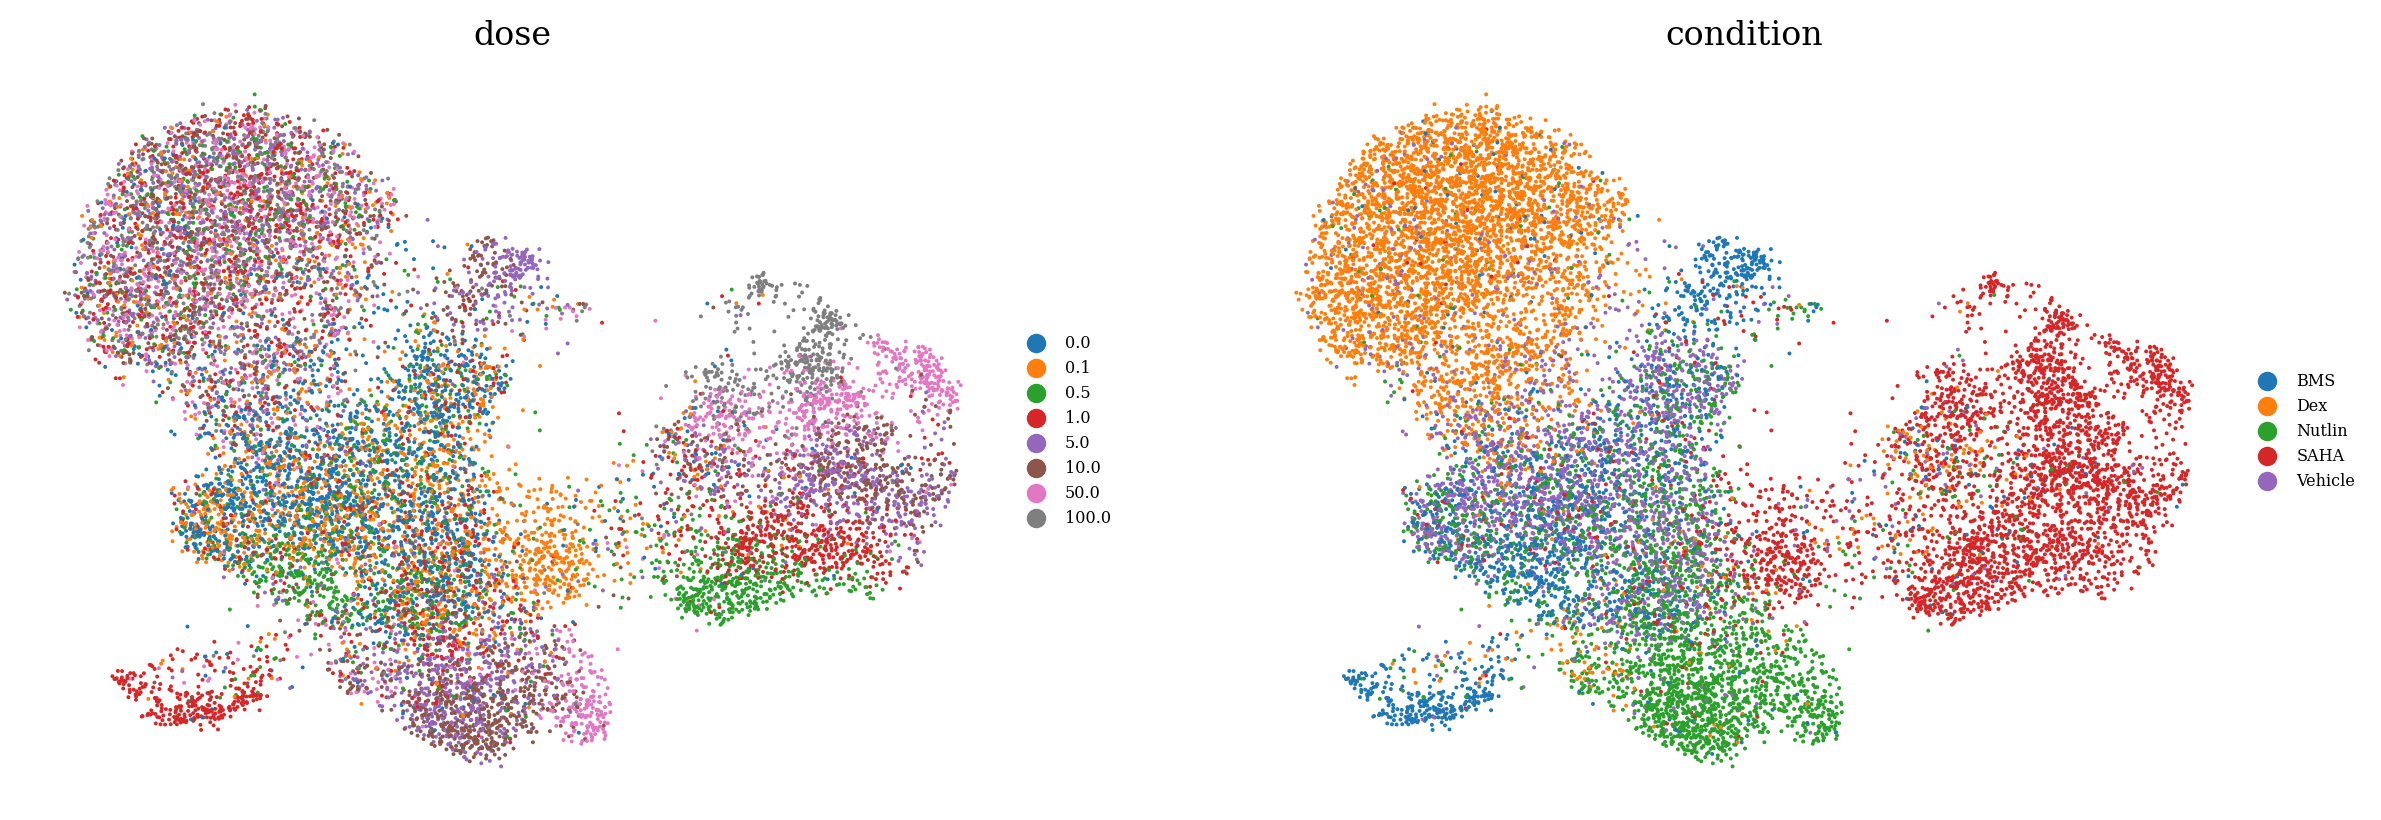

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

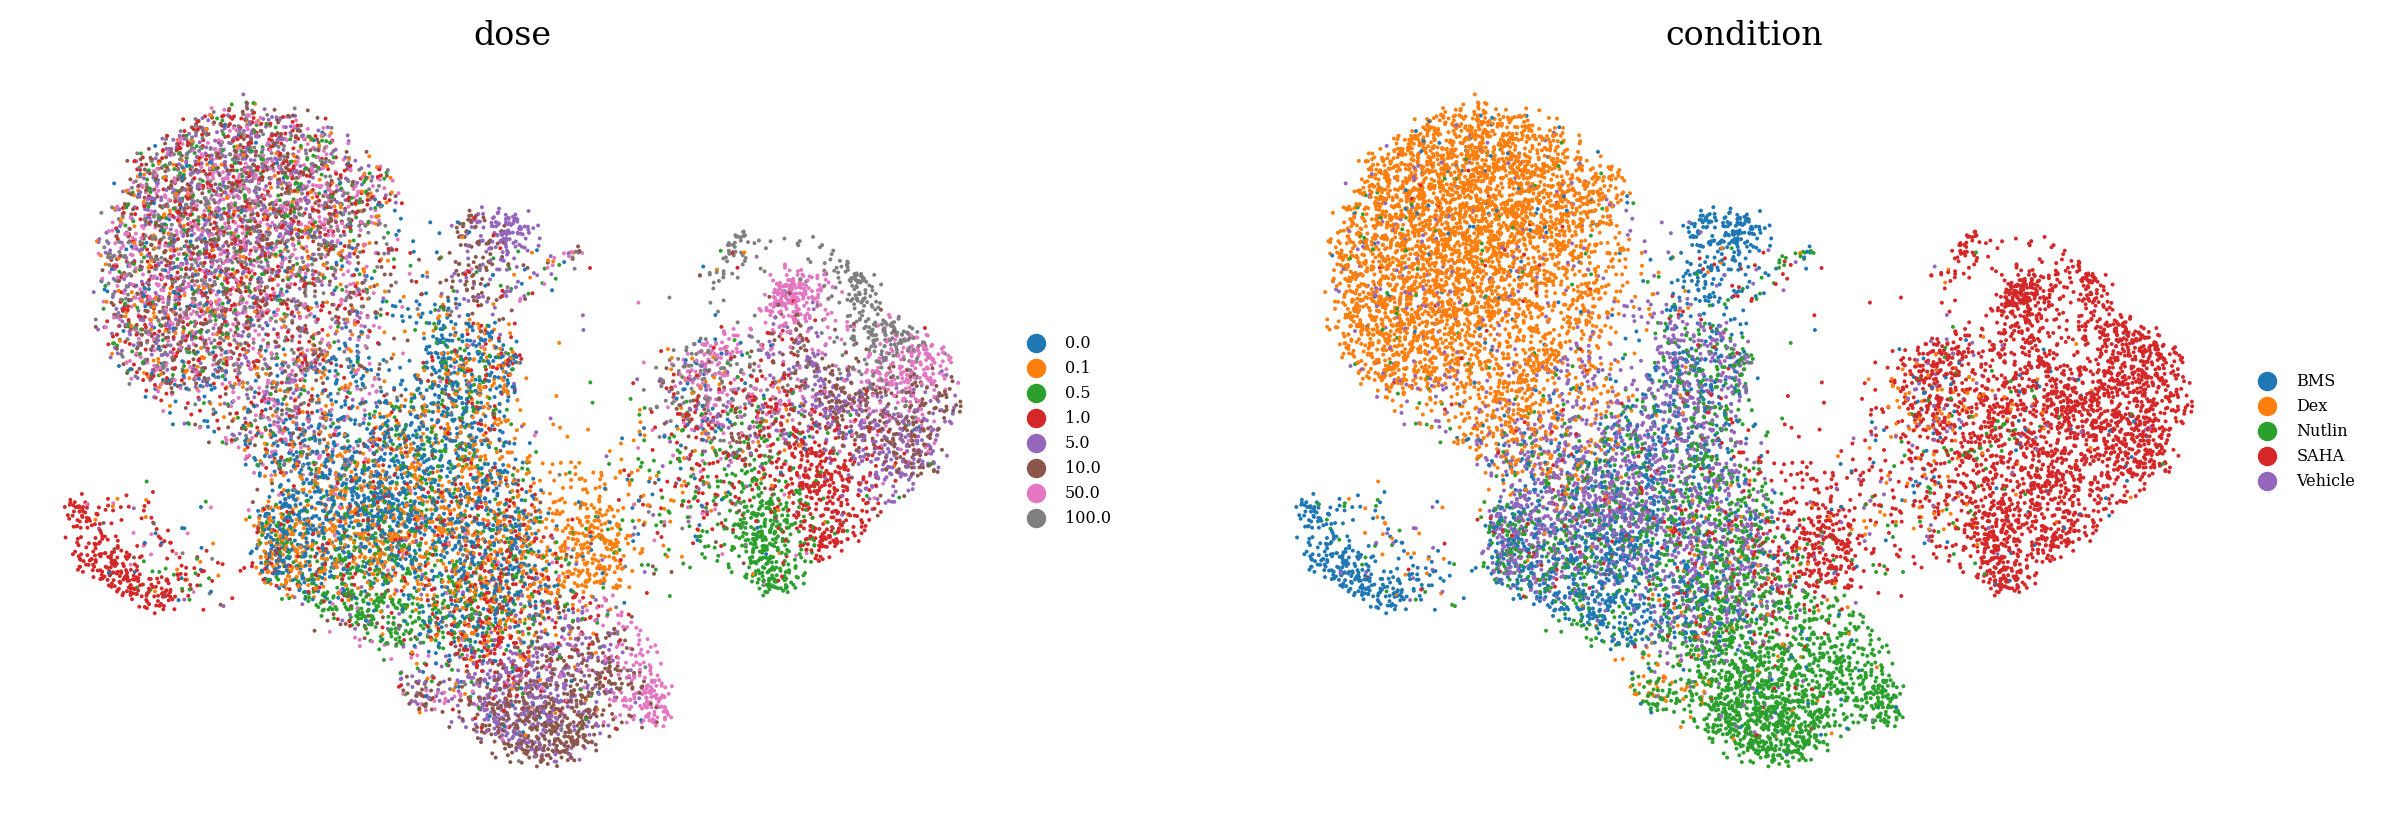

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  3%|▎         | 15/463 [00:00<00:03, 145.31it/s]

  9%|▊         | 40/463 [00:00<00:02, 204.71it/s]

 14%|█▍        | 65/463 [00:00<00:01, 222.04it/s]

 19%|█▉        | 90/463 [00:00<00:01, 230.00it/s]

 25%|██▍       | 115/463 [00:00<00:01, 234.54it/s]

 30%|███       | 140/463 [00:00<00:01, 237.28it/s]

 36%|███▌      | 165/463 [00:00<00:01, 239.16it/s]

 41%|████      | 190/463 [00:00<00:01, 240.25it/s]

 46%|████▋     | 215/463 [00:00<00:01, 241.04it/s]

 52%|█████▏    | 240/463 [00:01<00:00, 241.74it/s]

 57%|█████▋    | 265/463 [00:01<00:00, 242.80it/s]

 63%|██████▎   | 290/463 [00:01<00:00, 243.51it/s]

 68%|██████▊   | 315/463 [00:01<00:00, 244.01it/s]

 73%|███████▎  | 340/463 [00:01<00:00, 244.53it/s]

 79%|███████▉  | 365/463 [00:01<00:00, 244.48it/s]

 84%|████████▍ | 390/463 [00:01<00:00, 244.48it/s]

 90%|████████▉ | 415/463 [00:01<00:00, 244.31it/s]

 95%|█████████▌| 440/463 [00:01<00:00, 244.60it/s]

100%|██████████| 463/463 [00:01<00:00, 238.69it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9951354815379824

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)